In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, models, transforms

import cv2

from matplotlib import pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import time
import pandas as pd

In [10]:
# 4*4*512*2

In [11]:
cuda = True

sad = 128
obd = 64
fd = 64
scaling_factor = 1
bs = 16

In [12]:
import copy

model_vgg = models.vgg16(pretrained=True)

for param in model_vgg.parameters():
    param.requires_grad = False


In [13]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(*[i for i in model_vgg.features][:23])
        ##model_vgg.features[:23]
        image_size = fd/8
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * image_size * image_size * 2, 4096),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4),
        )

    def forward(self, x1 ,x2):

        x1 = self.features(x1)
        x2 = self.features(x2)
#         print x1.shape
        x = torch.cat((x1, x2))
        x = x.view(-1, self.num_flat_features(x)*2)
        x = self.classifier(x)
        return x

    def init_w(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                m.bias.data.fill_(1)
                m.weight.data.normal(0, 0.005)
                
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()

if cuda:
    net = net.cuda()
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    

In [33]:
# img = cv2.imread('example.jpg',1)
img = cv2.imread('details.jpg',1)

def crop(img, lu, rb, trans=False):
    w = img.shape[0]
    h = img.shape[1]
    try:
        lu = list(map(int, lu))
        rb = list(map(int, rb))

        if lu[0] < 0:
            lu[0] = 0 

        if lu[1] < 0:
            lu[1] = 0 

        if rb[0] > img.shape[1]:
            rb[0] = img.shape[1]

        if rb[1] > img.shape[0]:
            rb[1] = img.shape[0] 

        if trans:
            img.transpose(1, 0, 2)[lu[0]:rb[0], lu[1]:rb[1]].transpose(1,0,3)
        return img[lu[1]:rb[1], lu[0]:rb[0]]
    except Exception as e:
        return np.array([])

def resize(img, h, w):
    return cv2.resize(img, (w, h)) 

def random_crop(sample, m=40):
    h = sample.shape[1]
    w = sample.shape[0]
    mw = m
    mh = m
    
    l = random.randint(0, w-mw)
#     r = random.randint(l+mw, w)
    r = l + mw
    
    u = random.randint(0, h-mh)
#     b = random.randint(u+mh, h)
    b = u + mh
    
    return crop(sample, (l, u), (r, b)), ((l, u), (r, b))
    
def display_boxes(img, boxL, boxT, boxO=None, re=False, ax=None):
#     print(boxL)
#     print(boxT)
#     print img, 1
    t = img
    cv2.rectangle(t,boxL[0],boxL[1],(255,0,0), 2)
#     print t, 2
    cv2.rectangle(t,boxT[0],boxT[1],(0,255,0), 2)
#     print t, 2.5
    if boxO is not None:
        cv2.rectangle(t,boxO[0],boxO[1],(0,0,255), 2)
    
#     print t, 3
#     t = t if not re else resize(t, 640, 640)
#     cv2.imshow('image', t)
#     print t, 4
    if ax is not None:
        tmp = np.array(t[:, :, 2])
        t[:, :, 2] = t[:, :, 0] 
        t[:, :, 0] = tmp
        ax.clear()
        ax.imshow(t)
    else:
        cv2.imshow('image', t)

def display(img, L, T, O=None, re=False, ax=None):
#     print(L, T)
    h = img.shape[0]
    w = img.shape[1]
    
    boxL = center_to_box(*L)
    boxT = center_to_box(*T)
    boxO = O if O is None else center_to_box(*O)
    display_boxes(img, boxL, boxT, boxO, re, ax)
    
def box_to_center(lu, rb):
    w = rb[0] - lu[0]
    h = rb[1] - lu[1]
    cx = (rb[0] + lu[0]) / 2
    cy = (rb[1] + lu[1]) / 2
    return cx, cy, w, h

    
def center_to_box(cx, cy, w, h, dtype=int):
    lu = dtype((cx - w/2)), dtype((cy - h/2))
    rb = dtype((cx + w/2)), dtype((cy + h/2))
    return lu, rb

    
# img = crop(img, (20, 20), (40, 100))
# img = resize(img, 20, 40)
# print(img.shape)

# tmp = np.array(img[:, :, 2])
# img[:, :, 2] = img[:, :, 0] 
# img[:, :, 0] = tmp

# img, _ = random_crop(img)
# plt.imshow(img)
# display(img, (0, 0, 0, 0), (0, 0, 0, 0))
# if cv2.waitKey(1) & 0xFF == ord('q'):
#             cv2.destroyAllWindows()

## Video Training

In [24]:
import glob
import os
import random

nob = 0

def load_annotations(folder):
    ann = folder.replace('/data/', '/annotations/', 1)+".ann"
    df = pd.DataFrame(list(map(lambda x: x.strip().split() ,open(ann).readlines())))

    df = df[[0, 3, 2, 1, 6]]
    df. columns = ['f', 'l', 'u', 'r', 'b']
    df['f'] = df['f'].astype(int)
    df['l'] = df['l'].astype(float)
    df['u'] = df['u'].astype(float)
    df['r'] = df['r'].astype(float)
    df['b'] = df['b'].astype(float)
    keys = sorted(df['f'])
    # keys[-1]
    remaining = pd.DataFrame({'f': list(set(range(1, keys[-1]))-set(keys))})
    df = pd.concat([df, remaining], axis=0)
    # remaining
    df = df.sort_values(['f'])
    df = df.set_index('f')
    df = df.interpolate()

    df['cx'] = (df['l'] + df['r'])/2
    df['cy'] = (df['u'] + df['b'])/2

    df['w'] = abs(df['r'] - df['l'])
    df['h'] = abs(df['b'] - df['u'])

    # df = df[['cx', 'cy', 'h', 'w']]

    chosen = random.sample(list(df.index[:-1]), 10)
    next_chosen = map(lambda x:x+1, chosen)
    # df[chosen]
    chosen_df = df.loc[chosen]
    chosen_df = chosen_df.reset_index()
    new_chosen_df = df.loc[next_chosen]
    new_chosen_df = new_chosen_df.reset_index()
    new_chosen_df.columns = ['n' + i for i in new_chosen_df.columns]
    df = pd.concat([chosen_df, new_chosen_df], axis=1)


    df['tcx'] = (df['ncx'] - df['cx']) / df['w']
    df['tcy'] = (df['ncy'] - df['cy']) / df['h']
    df['tw'] = df['nw'] / df['w']
    df['th'] = df['nh'] / df['h']
    
    df['f'] = df['f'].astype(int)
    df['nf'] = df['nf'].astype(int)
    
    return df.fillna(0)
    
k = 2
def load(folder, show=False):
    df = load_annotations(folder)
    data = []
    to_append = 0
    images = []
#     print(len(df.index))
    for _, row in df.iterrows():
        img = int(row['f'])
        img = os.path.join(folder, "%08d.jpg"%img)
        img = cv2.imread(img,1)#.transpose(1, 0, 2)
        oimg = img.copy()
                           
        nimg = int(row['nf'])
        nimg = os.path.join(folder, "%08d.jpg"%nimg)
        nimg = cv2.imread(nimg,1)#.transpose(1, 0, 2)
        onimg = nimg.copy()
        
        images.append((oimg, onimg))
        
        if show:
            display(onimg, (row['ncx'], row['ncy'], row['nw'], row['nh']), (row['cx'], row['cy'], row['w'], row['h']))
            time.sleep(10)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
#                 break
        
        
        img = crop(img, (row['cx'] - row['w']/2, row['cy'] - row['h']/2), (row['cx'] + row['w']/2, row['cy'] + row['h']/2))
#         print(img.shape, row[['l', 'r', 'b','u']])
        if not all(img.shape):
#             print(img.shape)
            to_append += 1
            continue
        img = resize(img, fd, fd)
        
        
        nimg = crop(nimg, (row['cx'] - row['w']/2*k, row['cy'] - row['h']/2*k), (row['cx'] + row['w']/2*k, row['cy'] + row['h']/2*k))
        
#         if show:
#             display(nimg, (0,0,0,0), (0,0,0,0))
#             time.sleep(1)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 cv2.destroyAllWindows()
#                 break
        nimg = resize(nimg, fd, fd)
       
        
        data.append((img, nimg, (row['tcx'], row['tcy'], row['tw'], row['th'])))        
    
    if not data:
        print(folder)
#         data, df, images = load(folder)
    data.extend(random.sample(data*bs,to_append))
    return data, df, images

folder = "../dataset/data/09-Confusion/09-Confusion_video00016"
batch = load(folder, False)

# b = ((0,0),(0,0))
# for f in sorted(glob.glob(folder+'/*')):
#     ind = int(os.path.split(f)[-1].split('.')[0])
#     img = cv2.imread(f,1)


#     b = t.get(ind, b)
#     display_boxes(img, b, b)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#             cv2.destroyAllWindows()
#             break


def get_batch():
    f = glob.glob('../dataset/data/*')
    folder = random.choice(glob.glob(random.choice(f)+"/*"))
    batch, ann, images = load(folder)
    X1, X2, Y = zip(*batch)
    X1, X2, Y = np.array(X1), np.array(X2), np.array(Y)
    return X1, X2, Y, ann, images

In [25]:
# load_annotations(folder)
# tensor_pool = []


In [26]:
%%time

import threading
# tensor_pool = []
limit = 15
stop = False

def populate_pool(batch_func):
    i = 10
    global stop
    while stop:
        try:
            X1, X2, tT, ann, images = batch_func()
        except:
            skipped += 1 
            continue

        tX1 = torch.Tensor((X1.transpose(0,3,1,2)/255)).float()
        tX2 = torch.Tensor((X2.transpose(0,3,1,2)/255)).float()
        if cuda:
            tX1 = tX1.cuda()
            tX2 = tX2.cuda()

        X1 = torch.autograd.Variable(tX1, requires_grad=True)
        X2 = torch.autograd.Variable(tX2, requires_grad=True)

    #     print(X1.size(), X2.size())
        tT = torch.Tensor(tT).float()
        if cuda:
            tT = tT.cuda()
        T = torch.autograd.Variable(tT, requires_grad=False)
        
        tensor_pool.append((X1, X2, T, ann, images))

        if i == 0 or not stop:
            return
        
        if len(tensor_pool) >= limit:
            time.sleep(300)
            tensor_pool.pop(0)
            tensor_pool.pop(0)
            tensor_pool.pop(0)
            tensor_pool.pop(0)
            tensor_pool.pop(0)
            
#         i-= 1
#         print i, len(tensor_pool)
#         break



CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 19.1 µs


In [27]:
%%time
# tensor_pool
if len(tensor_pool) < 10:
    pop_thread = threading.Thread(target=populate_pool, args=(get_batch,))
    pop_thread2 = threading.Thread(target=populate_pool, args=(get_batch,))
    pop_thread3 = threading.Thread(target=populate_pool, args=(get_batch,))


    stop = True
    pop_thread.start()
    pop_thread2.start()
    pop_thread3.start()

    print("Populating Cache")
    while len(tensor_pool) < min(10, limit):
        time.sleep(1)
        print "\r %d / %d"%(len(tensor_pool), limit),
    # time.sleep(10)
    stop = False
    pop_thread.join()
    pop_thread2.join()
    pop_thread3.join()

NameError: name 'tensor_pool' is not defined

In [ ]:
len(tensor_pool)

In [ ]:
%matplotlib notebook
m = 100
n = 100
stop = True
pop_thread = threading.Thread(target=populate_pool, args=(get_batch,))

pop_thread.start()

# time.sleep(10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


caseNo = 30000
sample = img


losses = []
cv2.destroyAllWindows()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr = 0.0000002)

# optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr = 0.00000002)
save_name = "net4"

if os.path.exists(save_name):
    net.load_state_dict(torch.load(save_name))


# for param in net.parameters():
#     param.requires_grad = True

# loss = nn.MSELoss()
loss = nn.L1Loss()

tim = time.time()
last_print = 0
last_disp = 0
skipped = 0
for i in tqdm(range(caseNo)):
    
    X1, X2, T, ann, images = random.choice(tensor_pool)
    
#     print(X1.size(), X2.size())
    Y = net(X1, X2) * scaling_factor
    l = loss(Y, T)

    losses.append(float(l.cpu().data.numpy()))
    if time.time() - tim > 5:
        tim = time.time()
        

        y = Y
        if cuda:
            y=Y.cpu()
        y=y.data.numpy()
        ncx = ann.loc[0]['w'] * y[0][0] + ann.loc[0]['cx']
        ncy = ann.loc[0]['h'] * y[0][1] + ann.loc[0]['cy']
        nw = ann.loc[0]['w'] * y[0][2]
        nh = ann.loc[0]['h'] * y[0][3]
        
#         display(images[0][1], (ncx, ncy, nw, nh), (ann['cx'][0], ann['cy'][0], ann['w'][0], ann['h'][0]), (ann['ncx'][0], ann['ncy'][0], ann['nw'][0], ann['nh'][0]))
        
        if (i - last_print) % 1000 >100:
            torch.save(net.state_dict(), save_name)
            last_print = i
            
    if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
    
    if i%25 == 0:
        ax.clear()
        pd.Series(losses)[-200:].plot()
        pd.ewma(pd.Series(losses), 100)[-200:].plot()
        fig.canvas.draw()
    l.backward()
    optimizer.step()

cv2.destroyAllWindows()

torch.save(net.state_dict(), save_name)

stop = False
pop_thread.join()
pd.Series(losses).plot()

In [ ]:
pd.Series(losses).plot()
plt.show()

In [ ]:
t = np.random.ranf(10)
((t>0.5).astype(int) + ((t<0.5)*-1))/32

In [ ]:
pd.ewma(pd.Series(losses), 25)[-200:].plot()

## Data Augmentation

In [ ]:
np.random.laplace(0, 0.1, size=(10))

In [ ]:

k = 2
def load1daug(folder, show=False, y_vary=True):
    df = load_annotations(folder)
    data = []
    to_append = 0
    images = []
#     Random
#     t = np.random.ranf(len(df.index))
#     r = np.random.ranf(len(df.index)) *100 + 2
#     xaug = ((t>0.5).astype(int) + ((t<0.5)*-1))/r
#     yaug = ((t>0.5).astype(int) + ((t<0.5)*-1))/r

# Laplace
    xaug = np.random.laplace(0, 0.1, size=len(df.index))
    yaug = np.random.laplace(0, 0.1, size=len(df.index))
    waug = np.random.laplace(1, 0.1, size=len(df.index))
    haug = np.random.laplace(1, 0.1, size=len(df.index))
    
    
    df['tcx'] = xaug
    df['tcy'] = yaug if y_vary else 0
    df['tw'] = 1
    df['th'] = 1
    
    df['x_delta'] = df['tcx'] * df['w']
    df['y_delta'] = df['tcy'] * df['h']
    
    
    
#     print(len(df.index))
    for _, row in df.iterrows():
        img = int(row['f'])
        img = os.path.join(folder, "%08d.jpg"%img)
        img = cv2.imread(img,1)#.transpose(1, 0, 2)
        oimg = img.copy()
                           
        nimg = int(row['f'])
        nimg = os.path.join(folder, "%08d.jpg"%nimg)
        nimg = cv2.imread(nimg,1)#.transpose(1, 0, 2)
        onimg = nimg.copy()
        
        images.append((oimg, onimg))
            
        if show:
            display(onimg, (row['ncx'], row['ncy'], row['nw'], row['nh']), (row['cx'], row['cy'], row['w'], row['h']))
            time.sleep(10)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
#                 break
        
        
        img = crop(img, (row['cx'] - row['w']/2, row['cy'] - row['h']/2), (row['cx'] + row['w']/2, row['cy'] + row['h']/2))
#         print(img.shape, row[['l', 'r', 'b','u']])
        if not all(img.shape):
#             print(img.shape)
            to_append += 1
            continue
        img = resize(img, fd, fd)
        
        
        nimg = crop(nimg, (row['cx'] - row['w']/2*k - row['x_delta'], row['cy'] - row['h']/2*k - row['y_delta']), (row['cx'] + row['w']/2*k, row['cy'] + row['h']/2*k))
        
#         if show:
#             display(nimg, (0,0,0,0), (0,0,0,0))
#             time.sleep(1)
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 cv2.destroyAllWindows()
#                 break
        nimg = resize(nimg, fd, fd)
       
        
        data.append((img, nimg, (row['tcx'], row['tcy'], row['tw'], row['th'])))        
    
    
        
    if not data:
        print(folder)
#         data, df, images = load(folder)
    data.extend(random.sample(data*bs,to_append))
    return data, df, images


def get_xaug_batch():
    f = glob.glob('../dataset/data/*')
    folder = random.choice(glob.glob(random.choice(f)+"/*"))
    batch, ann, images = load1daug(folder)
    X1, X2, Y = zip(*batch)
    X1, X2, Y = np.array(X1), np.array(X2), np.array(Y)

    
    
    return X1, X2, Y, ann, images

def get_mixed():
    a = random.randint(0, 2)
    return get_batch() if a%2 == 1 else get_xaug_batch()

In [ ]:
tensor_pool = []

In [ ]:
limit = 100

pop_thread = threading.Thread(target=populate_pool, args=(get_xaug_batch,))
pop_thread2 = threading.Thread(target=populate_pool, args=(get_xaug_batch,))
pop_thread3 = threading.Thread(target=populate_pool, args=(get_xaug_batch,))


stop = True
pop_thread.start()
pop_thread2.start()
pop_thread3.start()

print("Populating Cache")
while len(tensor_pool) < 20:
    time.sleep(1)
    print "\r %d / %d"%(len(tensor_pool), limit),
# time.sleep(10)
stop = False
pop_thread.join()
pop_thread2.join()
pop_thread3.join()

In [ ]:
%matplotlib notebook
m = 100
n = 100
stop = True
pop_thread = threading.Thread(target=populate_pool, args=(get_mixed,))

pop_thread.start()

# time.sleep(10)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()


caseNo = 30000
sample = img


losses = []
cv2.destroyAllWindows()

# optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr = 0.0000001)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr = 0.00000002)
save_name = "net4"

if os.path.exists(save_name):
    net.load_state_dict(torch.load(save_name))

# for param in net.parameters():
#     param.requires_grad = True

# loss = nn.MSELoss()
loss = nn.L1Loss()

tim = time.time()
last_print = 0
last_disp = 0
skipped = 0
for i in tqdm(range(caseNo)):
    
    X1, X2, T, ann, images = random.choice(tensor_pool)
    
    Y = net(X1, X2) * scaling_factor
    l = loss(Y, T)

    losses.append(float(l.cpu().data.numpy()))
    if time.time() - tim > 5:
        tim = time.time()

        y = Y
        if cuda:
            y=Y.cpu()
        y=y.data.numpy()
        ncx = ann.loc[0]['w'] * y[0][0] + ann.loc[0]['cx']
        ncy = ann.loc[0]['h'] * y[0][1] + ann.loc[0]['cy']
        nw = ann.loc[0]['w'] * y[0][2]
        nh = ann.loc[0]['h'] * y[0][3]
        
#         display(images[0][1], (ncx, ncy, nw, nh), (ann['cx'][0], ann['cy'][0], ann['w'][0], ann['h'][0]), (ann['ncx'][0], ann['ncy'][0], ann['nw'][0], ann['nh'][0]))
        
        if (i - last_print) % 1000 >100:
            torch.save(net.state_dict(), save_name)
            
    if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

    if time.time() - last_disp > 2:
        ax.clear()
        pd.Series(losses)[-200:].plot()
        pd.ewma(pd.Series(losses), 100)[-200:].plot()
        fig.canvas.draw()
        last_disp = time.time()
    l.backward()
    optimizer.step()

cv2.destroyAllWindows()

torch.save(net.state_dict(), save_name)

stop = False
pop_thread.join()
pd.Series(losses).plot()

In [ ]:
plt.show()

## Play Tracking

<IPython.core.display.Javascript object>


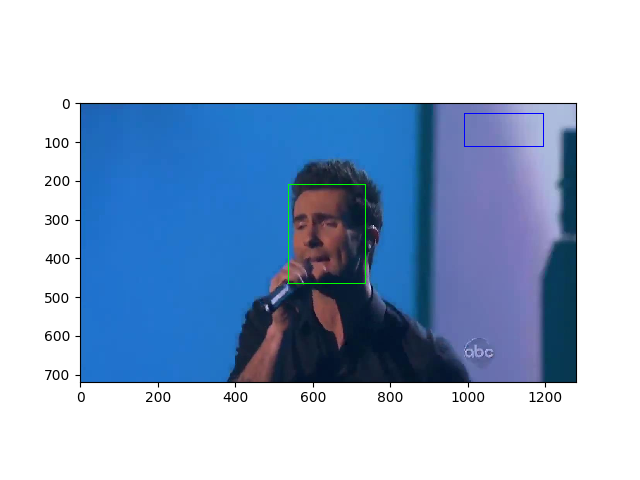

/home/travis/miniconda/conda-bld/work/opencv-2.4.11/modules/imgproc/src/imgwarp.cpp:1968: error: (-215) ssize.area() > 0 in function resize



KeyboardInterrupt: 

In [35]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()



# for i in range(1,33):
#     play('../dataset/data/02-SurfaceCover/02-SurfaceCover_video'+ '%05d'%i)
    
#     play('../dataset/data/01-Light/01-Light_video'+ '%05d'%i)
# play('../dataset/data/01-Light/01-Light_video00002')
# play('../dataset/data/01-Light/01-Light_video00003')
save_name='net4'
if os.path.exists(save_name):
    net.load_state_dict(torch.load(save_name))

def tracking(first_frame, remaining_frames, cx, cy, w, h, df=None):
#     print(cx, cy, w, h)
    for i, frame in enumerate(remaining_frames):
        j = i + 2
        x1 = crop(first_frame, (cx - w/2, cy - h/2), (cx + w/2, cy + h/2))
        x1 = resize(x1, fd, fd).transpose(2, 0, 1)/255
#         display(x1.transpose(1, 2, 0), ((0, 0,0, 0)), ((0, 0, 0, 0)))
#         cv2.waitKey(1)
#         time.sleep(1)
        
        x2 = crop(frame, (cx - w/2*k, cy - h/2*k), (cx + w/2*k, cy + h/2*k))
        x2 = resize(x2, fd, fd).transpose(2, 0, 1)/255
#         display(x2.transpose(1, 2, 0), ((0, 0,0, 0)), ((0, 0, 0, 0)))
#         cv2.waitKey(1)
#         time.sleep(1)
        
        x1 = torch.Tensor([x1.astype(float)]).float().cuda()
        x2 = torch.Tensor([x2.astype(float)]).float().cuda()
        x1 = torch.autograd.Variable(x1, requires_grad=False)
        x2 = torch.autograd.Variable(x2, requires_grad=False)
    
#         print(x1.size(), x2.size())
        y = net(x1, x2)
        y = y.cpu().data.numpy()
        ncx = w * y[0][0] + cx
        ncy = h * y[0][1] + cy
        nw = w * y[0][2]
        nh = h * y[0][3]
#         display(frame, (ncx, ncy, nw, nh), (ncx, ncy, nw, nh))
#         return 
#         print(ncx, ncy, nw, nh, y[0])
#         print(df['cx'][j], df['cy'][j], df['w'][j], df['h'][j])
        
#         ax.clear()
#         ax.imshow(frame)
#         fig.canvas.draw()
#         display(frame, (df['cx'][j], df['cy'][j], df['w'][j], df['h'][j]), (df['cx'][j], df['cy'][j], df['w'][j], df['h'][j]), ax=ax)
        
        display(frame, (ncx, ncy, nw, nh), (df['cx'][j], df['cy'][j], df['w'][j], df['h'][j]), ax=ax)
        fig.canvas.draw()
    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break
        time.sleep(1/30)
        cx, cy, w, h = ncx, ncy, nw, nh
        first_frame = frame
        
        
def track_vid(folder):
    ann = folder.replace('/data/', '/annotations/', 1)+".ann"
    df = pd.DataFrame(list(map(lambda x: x.strip().split() ,open(ann).readlines())))

    df = df[[0, 3, 2, 1, 6]]
    df. columns = ['f', 'l', 'u', 'r', 'b']
    df['f'] = df['f'].astype(int)
    df['l'] = df['l'].astype(float)
    df['u'] = df['u'].astype(float)
    df['r'] = df['r'].astype(float)
    df['b'] = df['b'].astype(float)
    keys = sorted(df['f'])
    # keys[-1]
    remaining = pd.DataFrame({'f': list(set(range(1, keys[-1]))-set(keys))})
    df = pd.concat([df, remaining], axis=0)
    # remaining
    df = df.sort_values(['f'])
    df = df.set_index('f')
    df = df.interpolate()

    df['cx'] = (df['l'] + df['r'])/2
    df['cy'] = (df['u'] + df['b'])/2

    df['w'] = abs(df['r'] - df['l'])
    df['h'] = abs(df['b'] - df['u'])
    cx, cy, w, h = df['cx'][1], df['cy'][1], df['w'][1], df['h'][1]
    
    
    firstimg = 1
    firstimg = os.path.join(folder, "%08d.jpg"%firstimg)
    firstimg = cv2.imread(firstimg,1)
    
    frames= []
    for i in range(2, 100):
        img = i
        img = os.path.join(folder, "%08d.jpg"%img)
        if os.path.exists(img):
            img = cv2.imread(img,1)
            frames.append(img)
        else:
            break
#     print(df['cx'][1])
    tracking(firstimg, frames, cx, cy, w, h, df)
    
# track_vid("../dataset/data/01-Light/01-Light_video00012")

for i in range(1, 10):
    folder ="../dataset/data/01-Light/01-Light_video%05d"%i
#     folder ="../dataset/data/12-MovingCamera/12-MovingCamera_video%05d"%i
#     folder ="../dataset/data/12-MovingCamera/12-MovingCamera_video%05d"%i
    
    if not os.path.exists(folder):
        break
    try:
        
        track_vid(folder)
    except Exception as e:
        print(e)
        continue

# track_vid("../dataset/data/12-MovingCamera/12-MovingCamera_video00021")


In [ ]:
i=5
folder ="../dataset/data/01-Light/01-Light_video%05d"%i
track_vid(folder)

999 [ 0.02457903  0.05061942 -0.08223155  0.10660891] [0.203125 0.46875  0.9375   0.984375]
